In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Import

In [ ]:
import os,sys 
import re
sys.path.append('/content/gdrive/My Drive/birdclef-2021')
sys.path.append('/content/gdrive/My Drive/birdclef-2021/basic_test/GAN')
path = ('/content/gdrive/My Drive/birdclef-2021/')

import time
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.preprocessing import minmax_scale

import soundfile
import librosa
import librosa.display
import IPython.display as ipd

img_height, img_width = 48, 128
BUFFER_SIZE = 1000
BATCH_SIZE = 32
sample_rate = 16384
sample_length = 2

input_dir = path + 'basic_test/birds/'
output_dir = path + 'basic_test/melspectrogram_dataset/'
model_dir = path + 'basic_test/'
soundscape_dir = path + 'basic_test/'

## Audio GAN

### Load Data

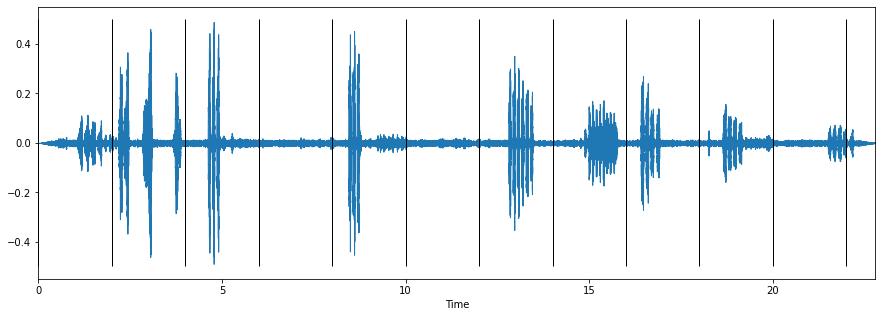

373440

In [ ]:
audio_path = input_dir + 'amerob/XC75498.ogg'

sig, rate = librosa.load(audio_path, sr=sample_rate, offset=None)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(sig, sr=sample_rate)
plt.vlines(range(0,24, sample_length),-.5,.5, linewidth=1)
plt.show()
len(sig)

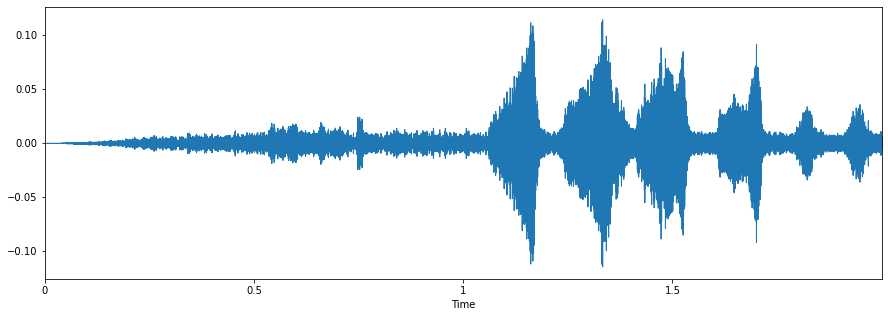

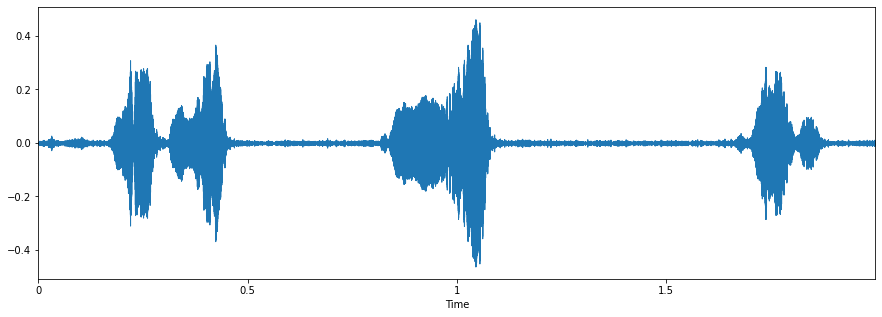

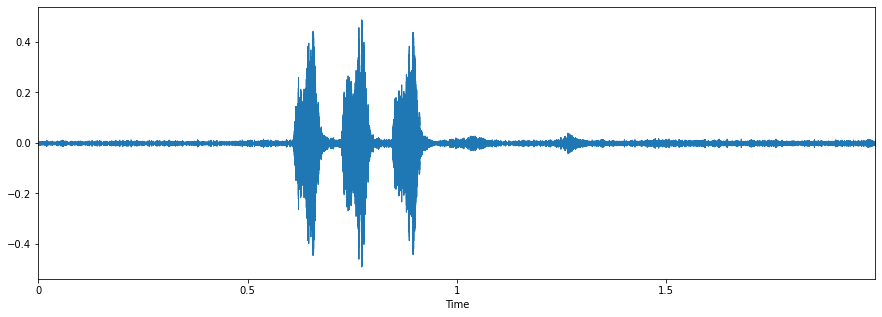

In [ ]:
n = np.floor_divide(len(sig), rate * sample_length) + 1
vec = sig.copy()
vec.resize(n * rate * sample_length)
vec = vec.reshape(n, rate * sample_length)

for v in vec[:3]:
  plt.figure(figsize=(15, 5))
  librosa.display.waveplot(v, sr=16384)
  plt.show()

soundfile.write(path + 'bird_test_orignial.wav', vec[0], sample_rate, 'PCM_24')

In [ ]:
vec.shape

(12, 32768)

In [ ]:
# Load metadata file
train = pd.read_csv(path + 'train_metadata.csv',)

file_list = train.loc[train['primary_label'] == 'amerob']['filename'].to_numpy()

segments = []

for file in tqdm(file_list):
  audio_path = input_dir + 'amerob/' + file
  sig, rate = librosa.load(audio_path, sr=sample_rate, offset=None)

  n = np.floor_divide(len(sig), rate * sample_length) + 1
  vec = sig.copy()
  vec.resize(n * rate * sample_length)
  vec = vec.reshape(n, rate * sample_length)

  segments.append(vec)

segments = np.concatenate(segments, axis=0)
np.save(path + 'amerob', segments)

In [ ]:
segments.shape

### Reload segments data

In [ ]:
segments = np.load(path + 'amerob.npy')

In [ ]:
segments.shape

(17896, 32768)

In [ ]:
audio_ds = tf.data.Dataset.from_tensor_slices(segments.reshape(-1,sample_rate*sample_length,1)).batch(32)

In [ ]:
audio_ds

<BatchDataset shapes: (None, 32768, 1), types: tf.float32>

### Create Model

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((64, 256)))
    assert model.output_shape == (None, 64, 256)

    model.add(layers.Conv1DTranspose(128, 25, strides=1, padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1DTranspose(64, 25, strides=4, padding='same', use_bias=False))
    assert model.output_shape == (None, 256, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1DTranspose(32, 25, strides=4, padding='same', use_bias=False))
    assert model.output_shape == (None, 1024, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv1DTranspose(16, 25, strides=4, padding='same', use_bias=False))
    assert model.output_shape == (None, 4096, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1DTranspose(8, 25, strides=4, padding='same', use_bias=False))
    assert model.output_shape == (None, 16384, 8)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1DTranspose(1, 25, strides=2, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 16384*2, 1)

    return model

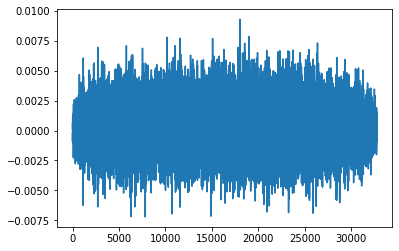

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
untrained_generated_audio = generator(noise, training=False)
plt.plot(untrained_generated_audio[0, :, 0])
plt.show()

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 64, 256)           0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 64, 128)           819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 128)           512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 128)           0

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(64, 25, strides=4, padding='same',
                                     input_shape=[16384*2, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(128, 25, strides=4, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(256, 25, strides=4, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(512, 25, strides=4, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(untrained_generated_audio)
print(decision)

tf.Tensor([[-1.8486979e-05]], shape=(1, 1), dtype=float32)


### Loss

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5) # 5
discriminator_optimizer = tf.keras.optimizers.Adam(1e-6) # 6

checkpoint_dir = path + 'GAN/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Train

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
def train(dataset, epochs):

  g_loss = []
  d_loss = []

  for epoch in range(epochs):
    start = time.time()

    for image_batch in tqdm(dataset):
      gen_loss, disc_loss = train_step(image_batch)

    g_loss.append(gen_loss)
    d_loss.append(disc_loss)

    # Save the model every few epochs
    if (epoch + 1) % 1 == 5:
      checkpoint.save(file_prefix = checkpoint_prefix)

      noise = tf.random.normal([1, 100])
      generated_audio = generator(noise, training=False)
      plt.plot(generated_audio[0, :, 0])
      plt.show()

      plt.plot(g_loss, label='Generator')
      plt.plot(d_loss, label='Discriminator')
      plt.legend()
      plt.show()

      soundfile.write(path + 'GAN/sounds/bird_test' + str(np.array(noise)[0,0])[3:] + '.wav', np.array(generated_audio[0, :, 0]), sample_rate, 'PCM_24')

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [ ]:
tf.device('/device:GPU:0')

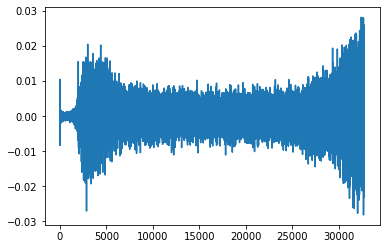

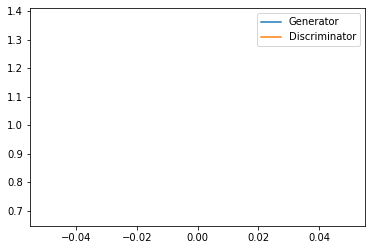

Time for epoch 1 is 82.27987885475159 sec


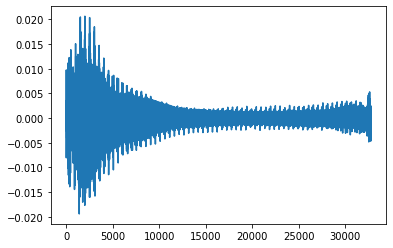

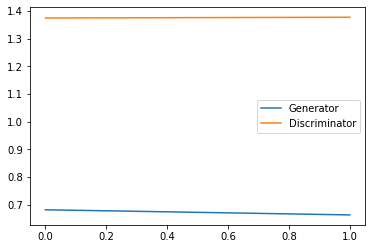

Time for epoch 2 is 82.53552055358887 sec


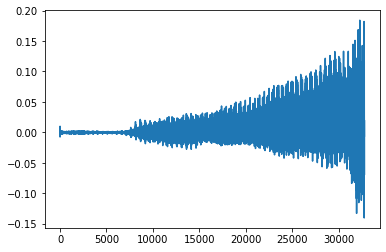

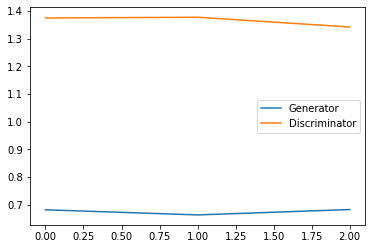

Time for epoch 3 is 82.69694304466248 sec


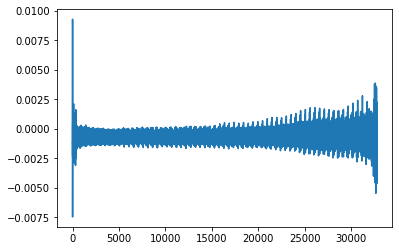

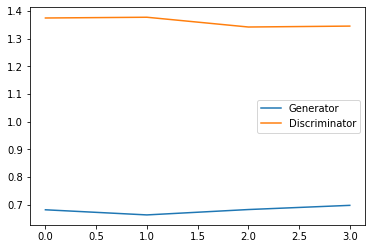

Time for epoch 4 is 83.81787419319153 sec


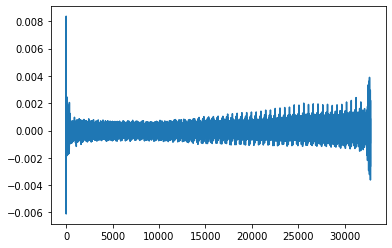

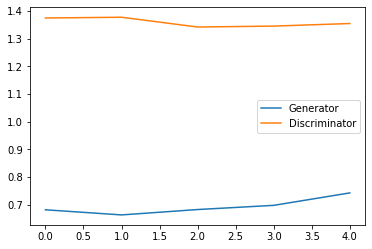

Time for epoch 5 is 84.03353381156921 sec


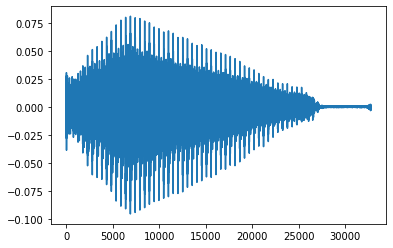

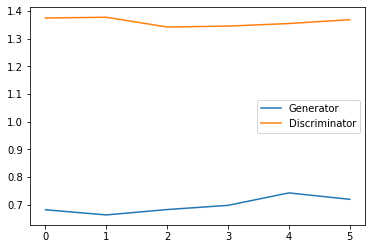

Time for epoch 6 is 83.83022665977478 sec


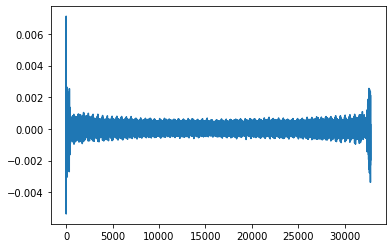

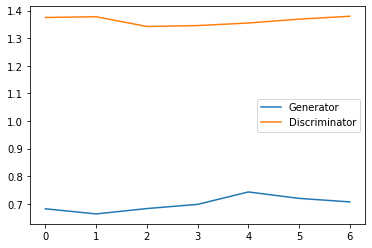

Time for epoch 7 is 84.09577059745789 sec


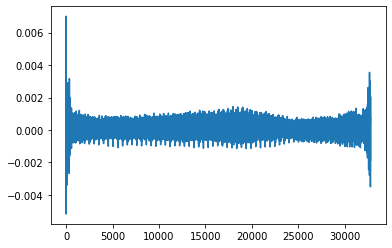

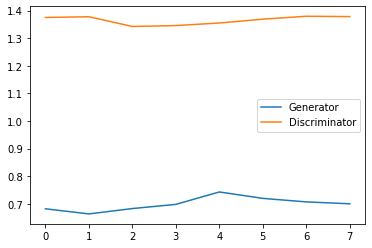

Time for epoch 8 is 83.81200194358826 sec


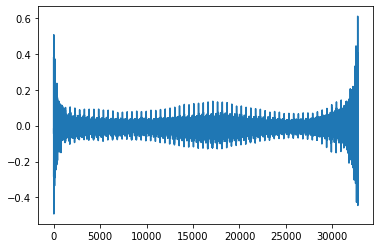

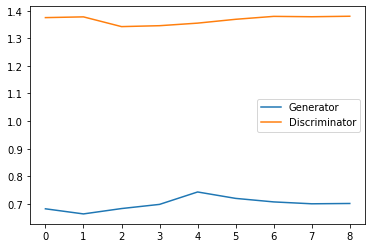

Time for epoch 9 is 82.77862811088562 sec


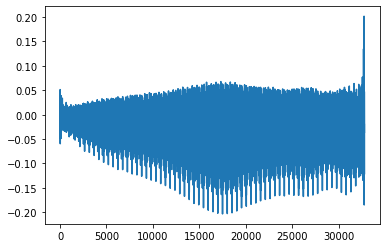

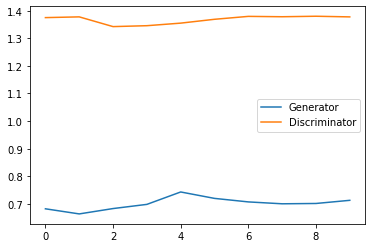

Time for epoch 10 is 82.84076595306396 sec


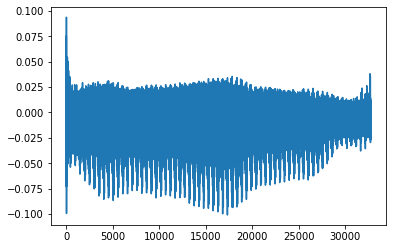

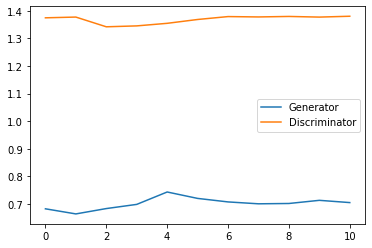

Time for epoch 11 is 84.19477319717407 sec


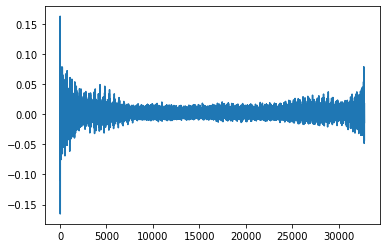

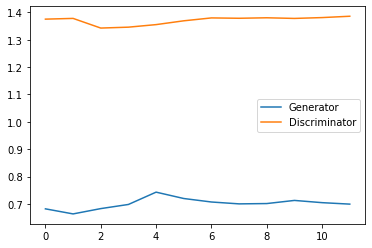

Time for epoch 12 is 82.76292085647583 sec


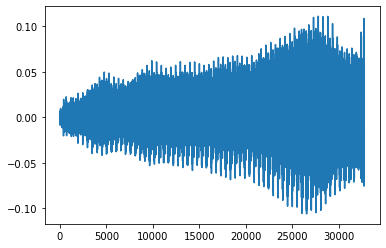

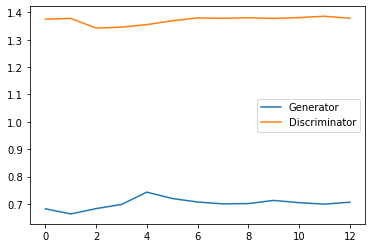

Time for epoch 13 is 82.53169536590576 sec


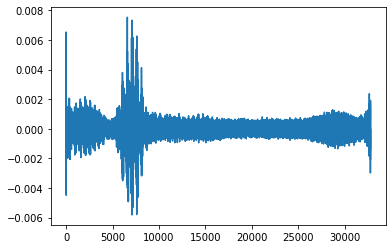

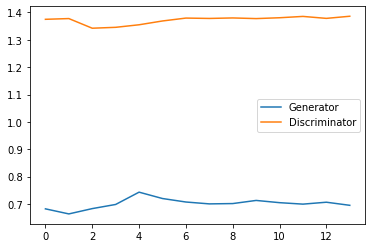

Time for epoch 14 is 82.49943971633911 sec


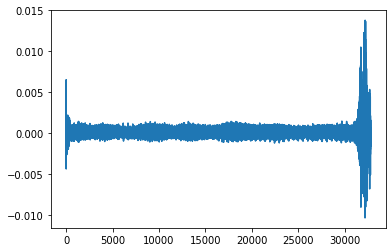

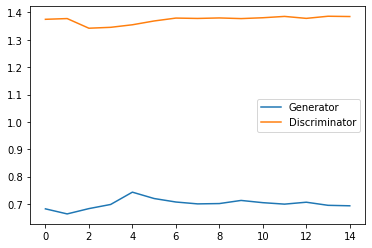

Time for epoch 15 is 83.85005211830139 sec


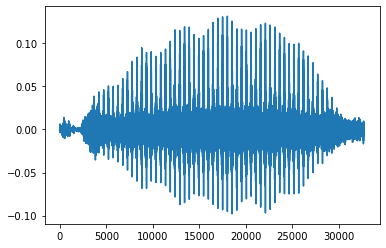

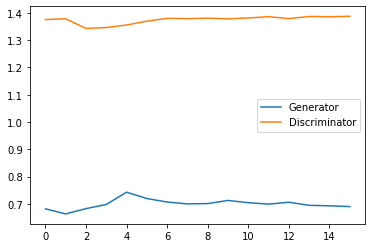

Time for epoch 16 is 83.00432395935059 sec


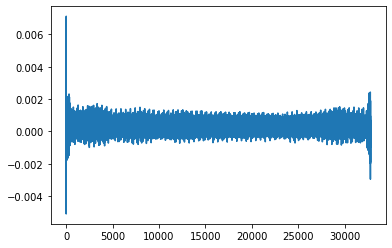

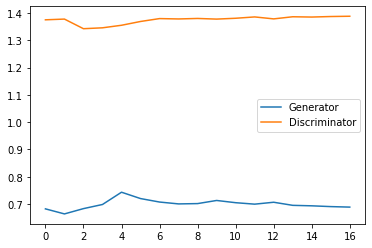

Time for epoch 17 is 82.54441285133362 sec


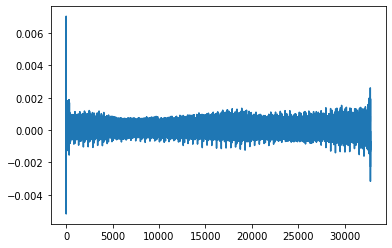

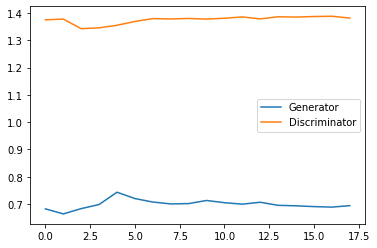

Time for epoch 18 is 82.77414274215698 sec


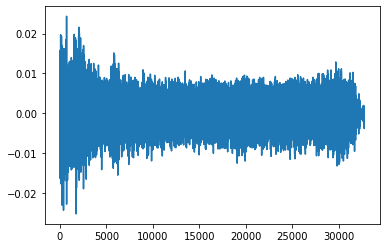

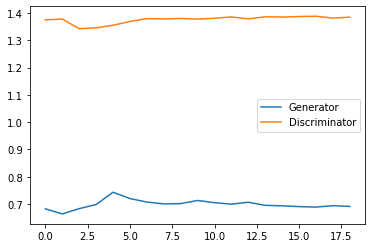

Time for epoch 19 is 83.86274671554565 sec


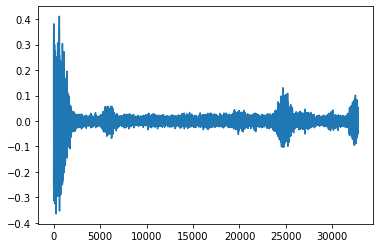

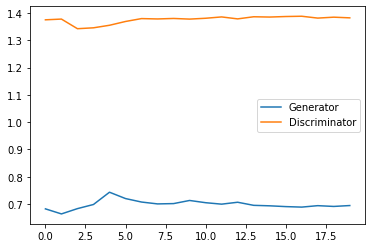

Time for epoch 20 is 84.29016423225403 sec


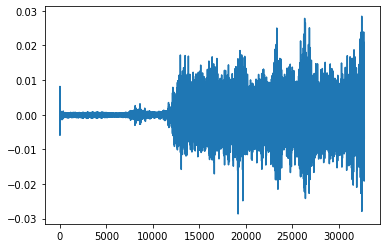

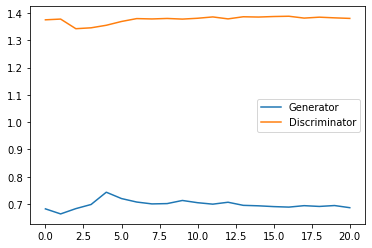

Time for epoch 21 is 83.91819453239441 sec


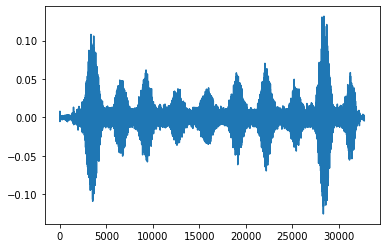

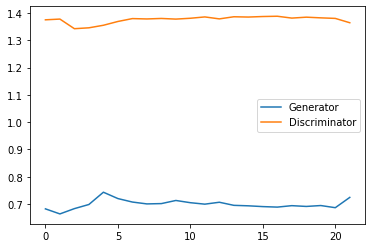

Time for epoch 22 is 82.77639579772949 sec


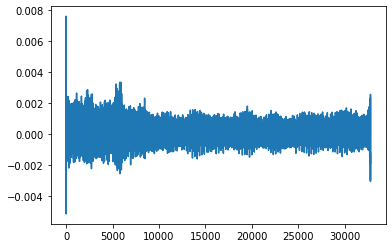

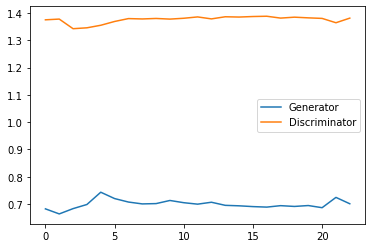

Time for epoch 23 is 83.92702960968018 sec


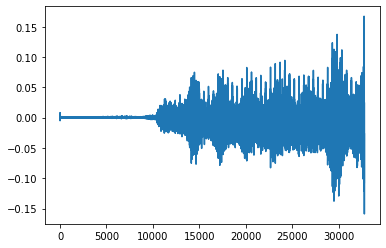

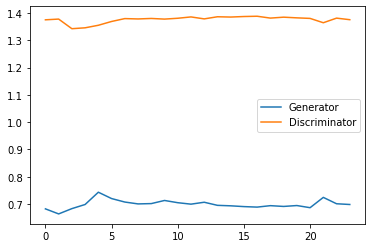

Time for epoch 24 is 82.48870301246643 sec


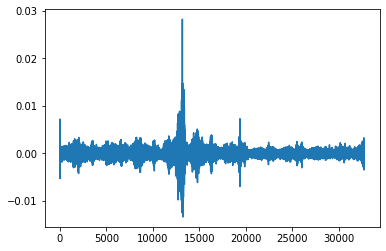

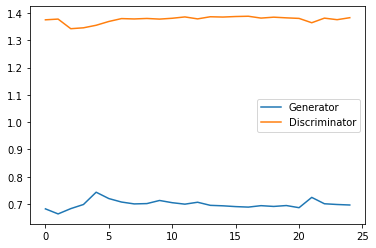

Time for epoch 25 is 84.01383090019226 sec


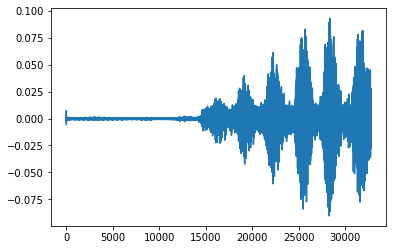

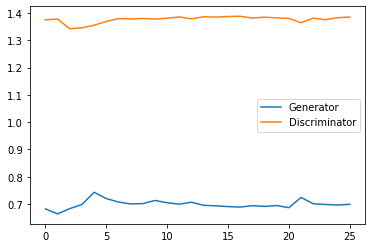

Time for epoch 26 is 84.00828456878662 sec


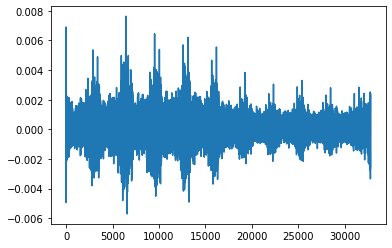

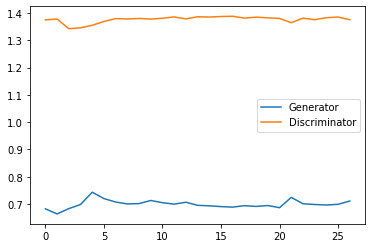

Time for epoch 27 is 82.95371866226196 sec


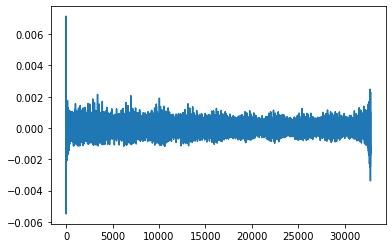

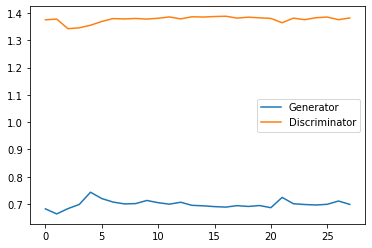

Time for epoch 28 is 82.66553902626038 sec


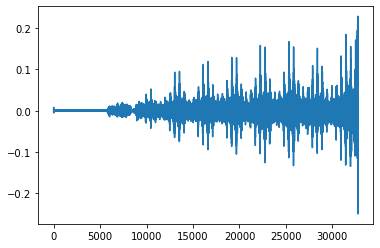

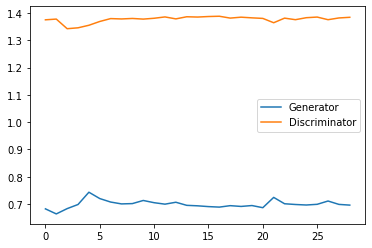

Time for epoch 29 is 83.15285539627075 sec


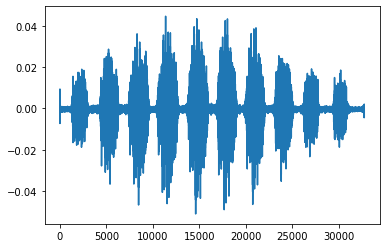

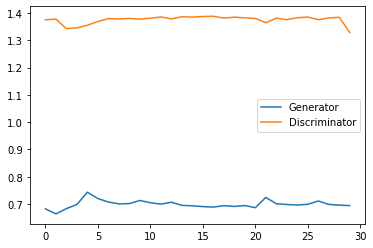

Time for epoch 30 is 82.69075083732605 sec


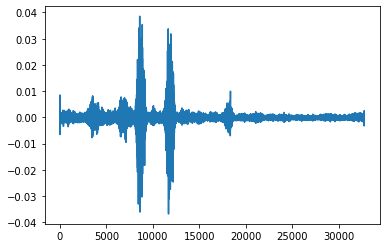

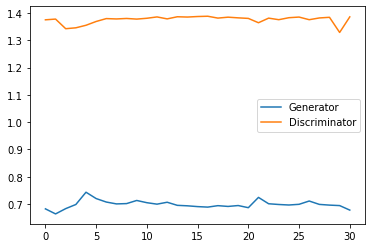

Time for epoch 31 is 82.89523124694824 sec


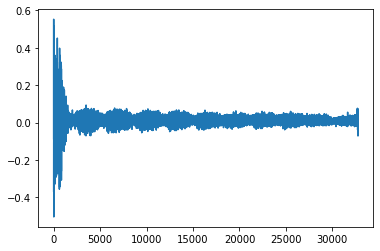

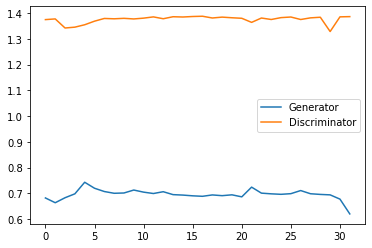

Time for epoch 32 is 82.5122697353363 sec


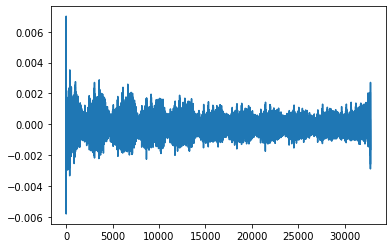

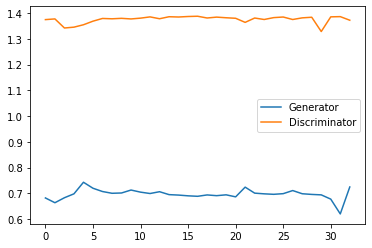

Time for epoch 33 is 83.05379986763 sec


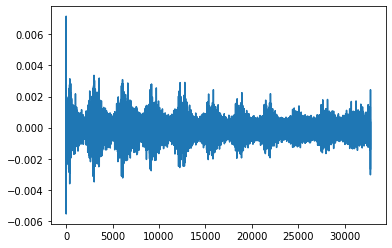

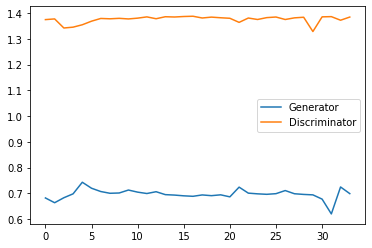

Time for epoch 34 is 82.57561874389648 sec


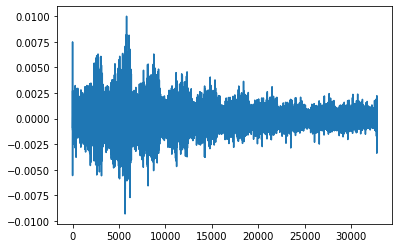

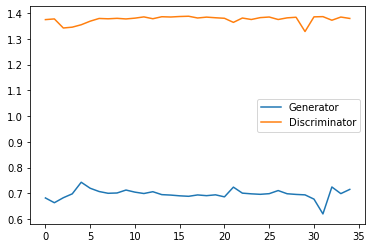

Time for epoch 35 is 82.84131860733032 sec


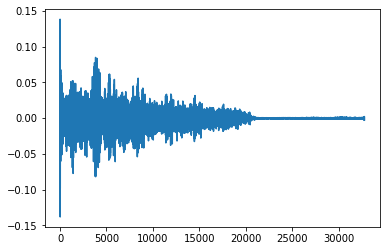

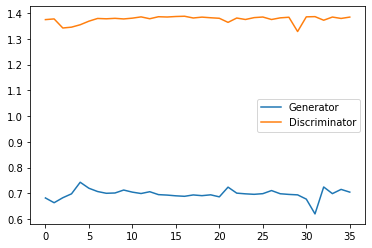

Time for epoch 36 is 82.5497236251831 sec


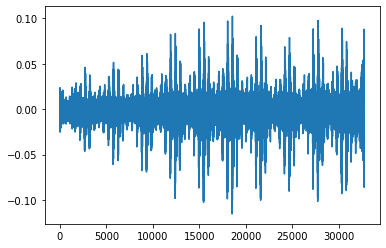

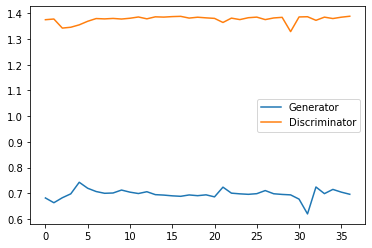

Time for epoch 37 is 83.94174313545227 sec


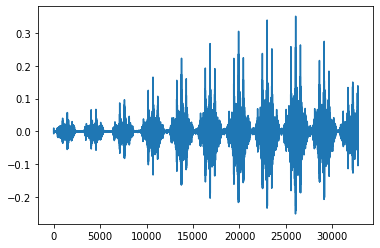

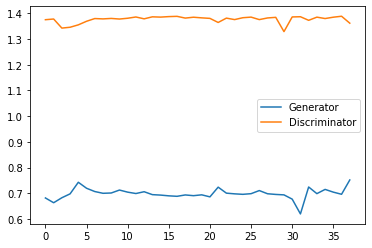

Time for epoch 38 is 82.57386922836304 sec


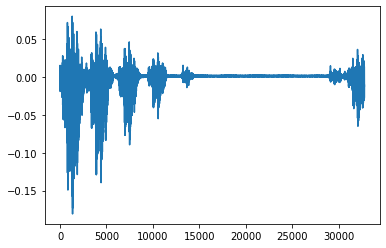

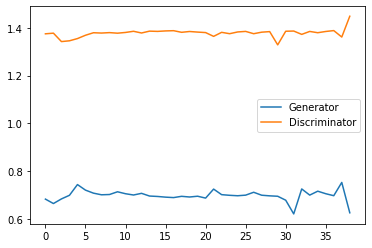

Time for epoch 39 is 82.57367825508118 sec


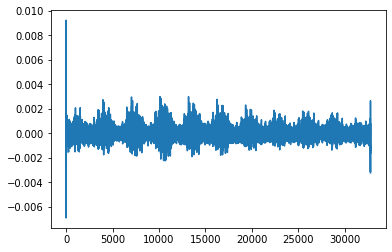

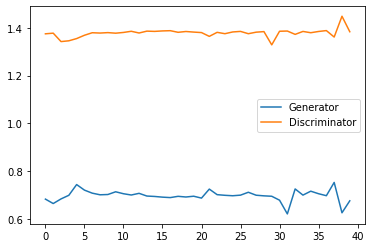

Time for epoch 40 is 82.48117589950562 sec


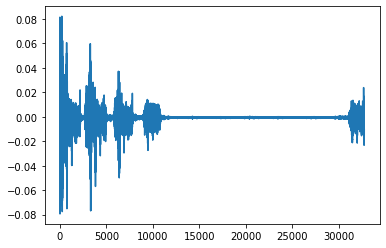

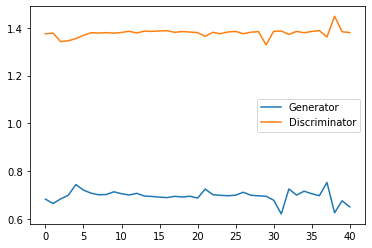

Time for epoch 41 is 82.51103854179382 sec


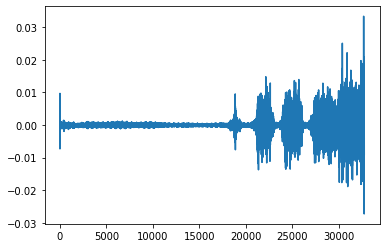

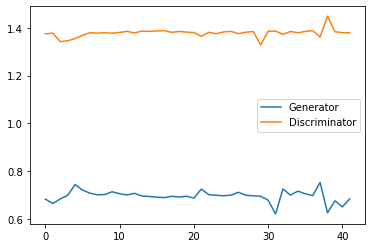

Time for epoch 42 is 84.25118613243103 sec


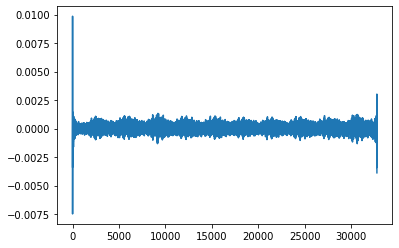

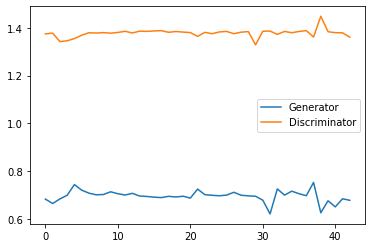

Time for epoch 43 is 82.67705345153809 sec


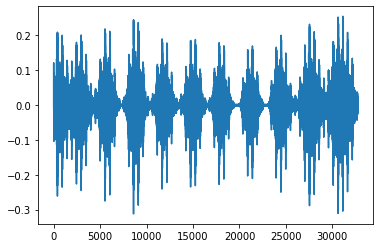

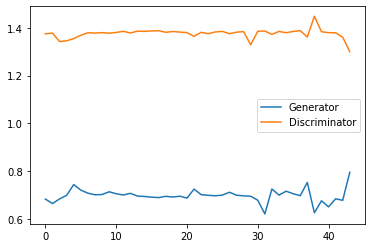

Time for epoch 44 is 82.8543291091919 sec


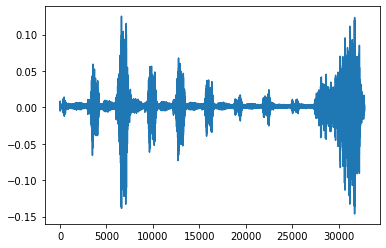

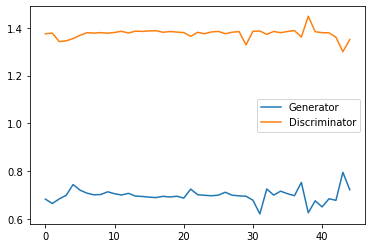

Time for epoch 45 is 82.6774332523346 sec


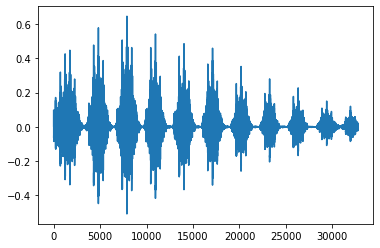

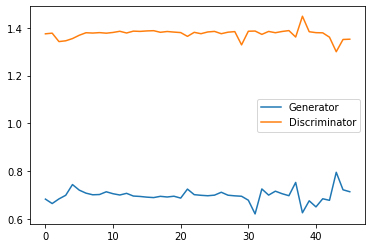

Time for epoch 46 is 82.90556907653809 sec


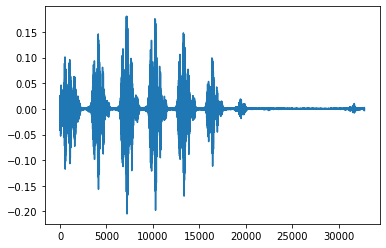

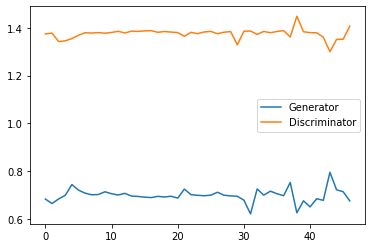

Time for epoch 47 is 82.89780521392822 sec


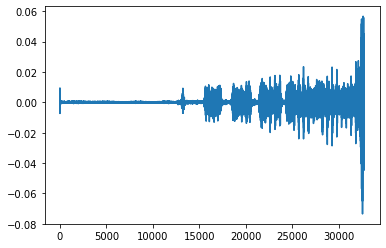

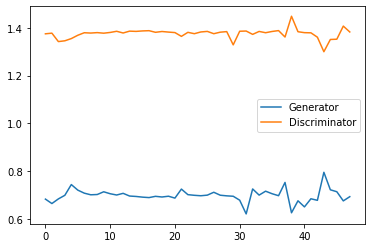

Time for epoch 48 is 82.75781321525574 sec


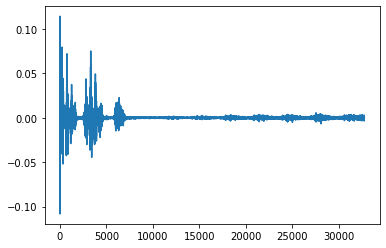

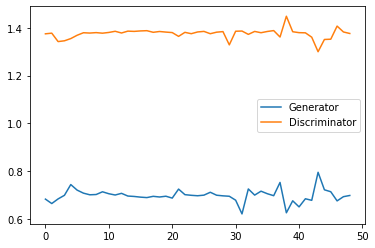

Time for epoch 49 is 82.7602047920227 sec


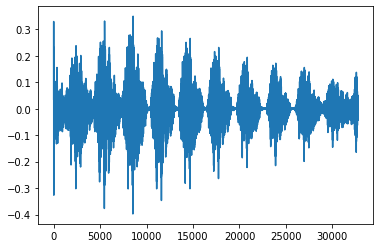

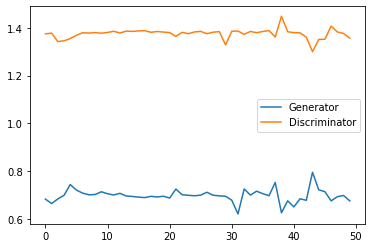

Time for epoch 50 is 82.63547396659851 sec


In [ ]:
train(audio_ds, EPOCHS)

### Load Model

In [ ]:
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(checkpoint_path)

### Export

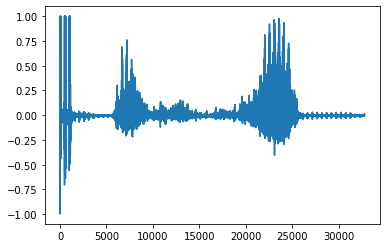

In [ ]:
noise = tf.random.normal([1, 100])
generated_audio = generator(noise, training=False)
plt.plot(generated_audio[0, :, 0])
plt.show()

In [ ]:
decision = discriminator(generated_audio)
print(decision)

tf.Tensor([[-2.011294]], shape=(1, 1), dtype=float32)


In [ ]:
scale_factor = 10
rate_factor = 1
scaled_sound = np.array(generated_audio[0, :, 0]) * scale_factor

ipd.Audio(data=scaled_sound, rate=sample_rate * rate_factor)

In [ ]:
soundfile.write(path + 'bird_test' + str(np.array(noise)[0,0])[3:] + '_' + str(scale_factor) + '.wav', scaled_sound, int(sample_rate * rate_factor), 'PCM_24')

In [ ]:
birdsong = []
clips = 10

for i in tqdm(range(clips)):
    noise = tf.random.normal([1, 100])
    generated_audio = generator(noise, training=False)
    birdsong.append(np.array(generated_audio[0, :, 0]) * scale_factor)

birdsong = np.concatenate(birdsong)

In [ ]:
ipd.Audio(data=birdsong, rate=sample_rate * rate_factor)

# Export plots

Text(0.5, 0, 'Sample')

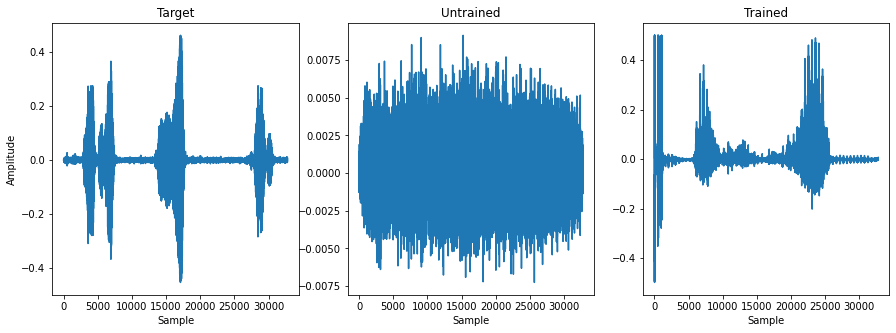

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(15, 5))

ax0.plot(vec[1])
ax0.set_title('Target')
ax0.set_xlabel('Sample')
ax0.set_ylabel('Amplitude')

ax1.plot(untrained_generated_audio[0, :, 0])
ax1.set_title('Untrained')
ax1.set_xlabel('Sample')

ax2.plot(generated_audio[0, :, 0]*.5)
ax2.set_title('Trained')
ax2.set_xlabel('Sample')